# Create a simple Bollinger-band trading strategy and then backtest 

In [102]:
!pip install --force matplotlib==2.2.4

     |████████████████████████████████| 12.8MB 8.7MB/s eta 0:00:01    |████████▊                       | 3.5MB 2.9MB/s eta 0:00:04
     |████████████████████████████████| 92kB 7.2MB/s eta 0:00:011
     |████████████████████████████████| 512kB 4.6MB/s eta 0:00:01
     |████████████████████████████████| 71kB 6.4MB/s eta 0:00:01
     |████████████████████████████████| 14.5MB 9.5MB/s eta 0:00:01    |█▌                              | 665kB 8.4MB/s eta 0:00:02     |████████████████████████▎       | 11.0MB 9.5MB/s eta 0:00:01
     |████████████████████████████████| 235kB 7.9MB/s eta 0:00:01
ERROR: tensorflow 2.3.0 has requirement h5py<2.11.0,>=2.10.0, but you'll have h5py 2.9.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.1 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement scipy==1.4.1, but you'll have scipy 1.3.1 which is incompatible.
ERROR: sparse-dot-topn 0.2.9 has requirement cython>=0.29.15, but you'll have

In [1]:
#import needed libraries
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import backtrader as bt
from datetime import datetime
import os
#import dataprep.eda as eda

from alpha_vantage.foreignexchange import ForeignExchange


In [11]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
plt.rcParams['figure.figsize'] = 16,9
pd.set_option('display.max_colwidth', -1)
pd.plotting.register_matplotlib_converters()
#plt.style.use('fivethirtyeight')

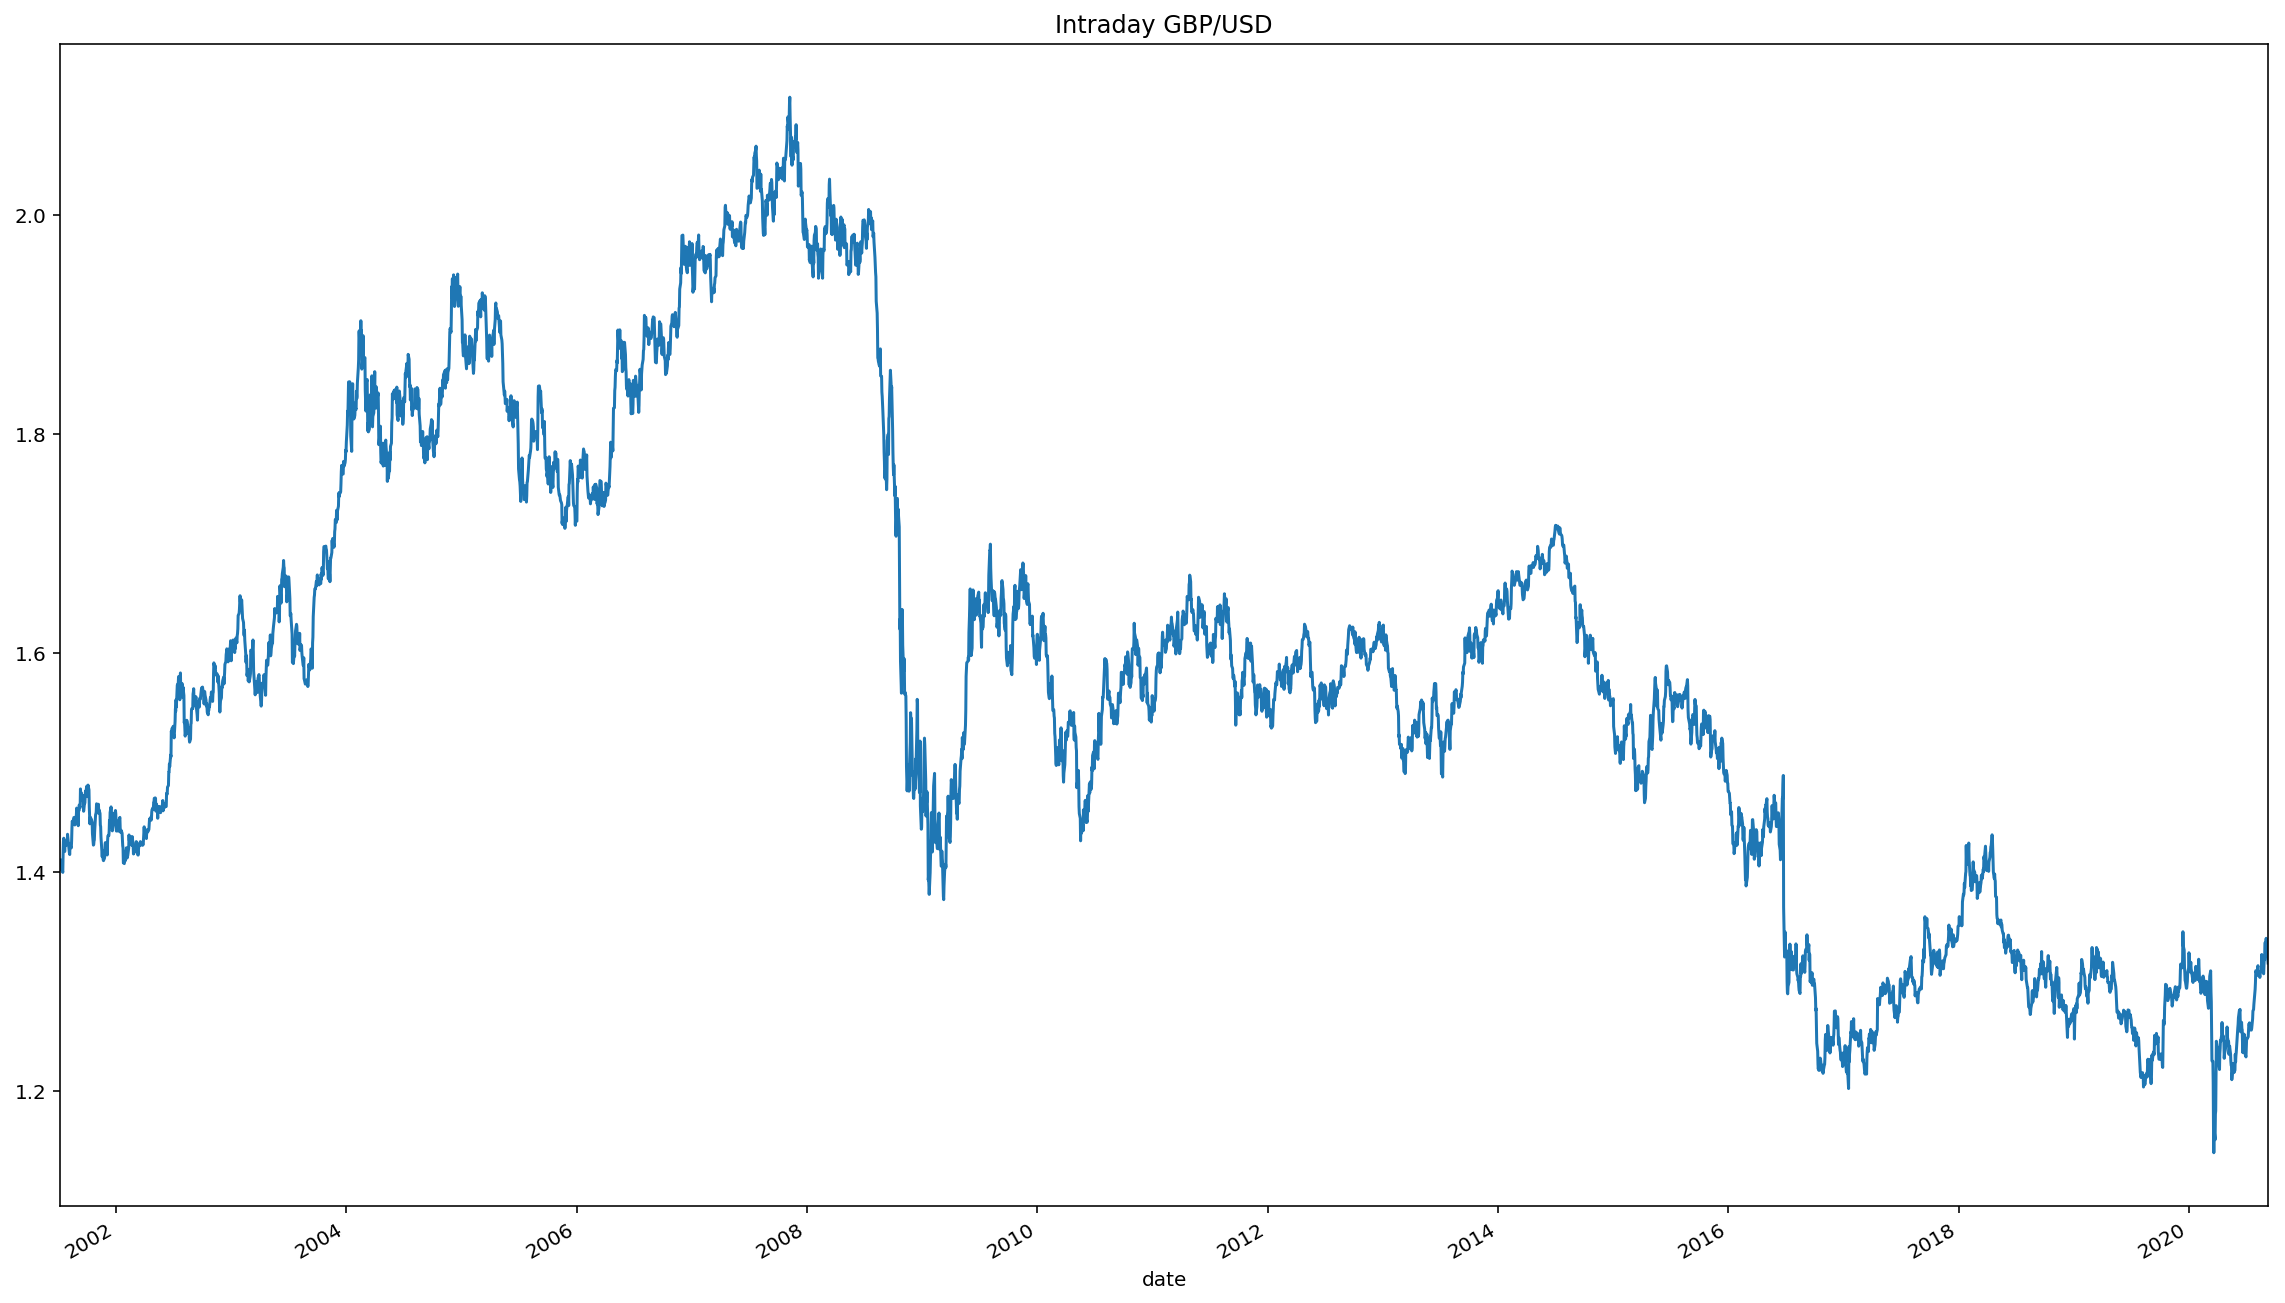

In [14]:
cc = ForeignExchange(key=os.environ['alpha_vantage_token'],output_format='pandas')
data_df, metadata_df = cc.get_currency_exchange_daily(from_symbol='GBP',to_symbol='USD', outputsize='full')
data_df['4. close'].plot()
plt.tight_layout()
plt.title('Intraday GBP/USD')
plt.show()

## Let's just look at 2010 onwards 

In [15]:
data_df.sort_index(inplace=True)

In [16]:
data_df = data_df.loc['2015-01-01':]

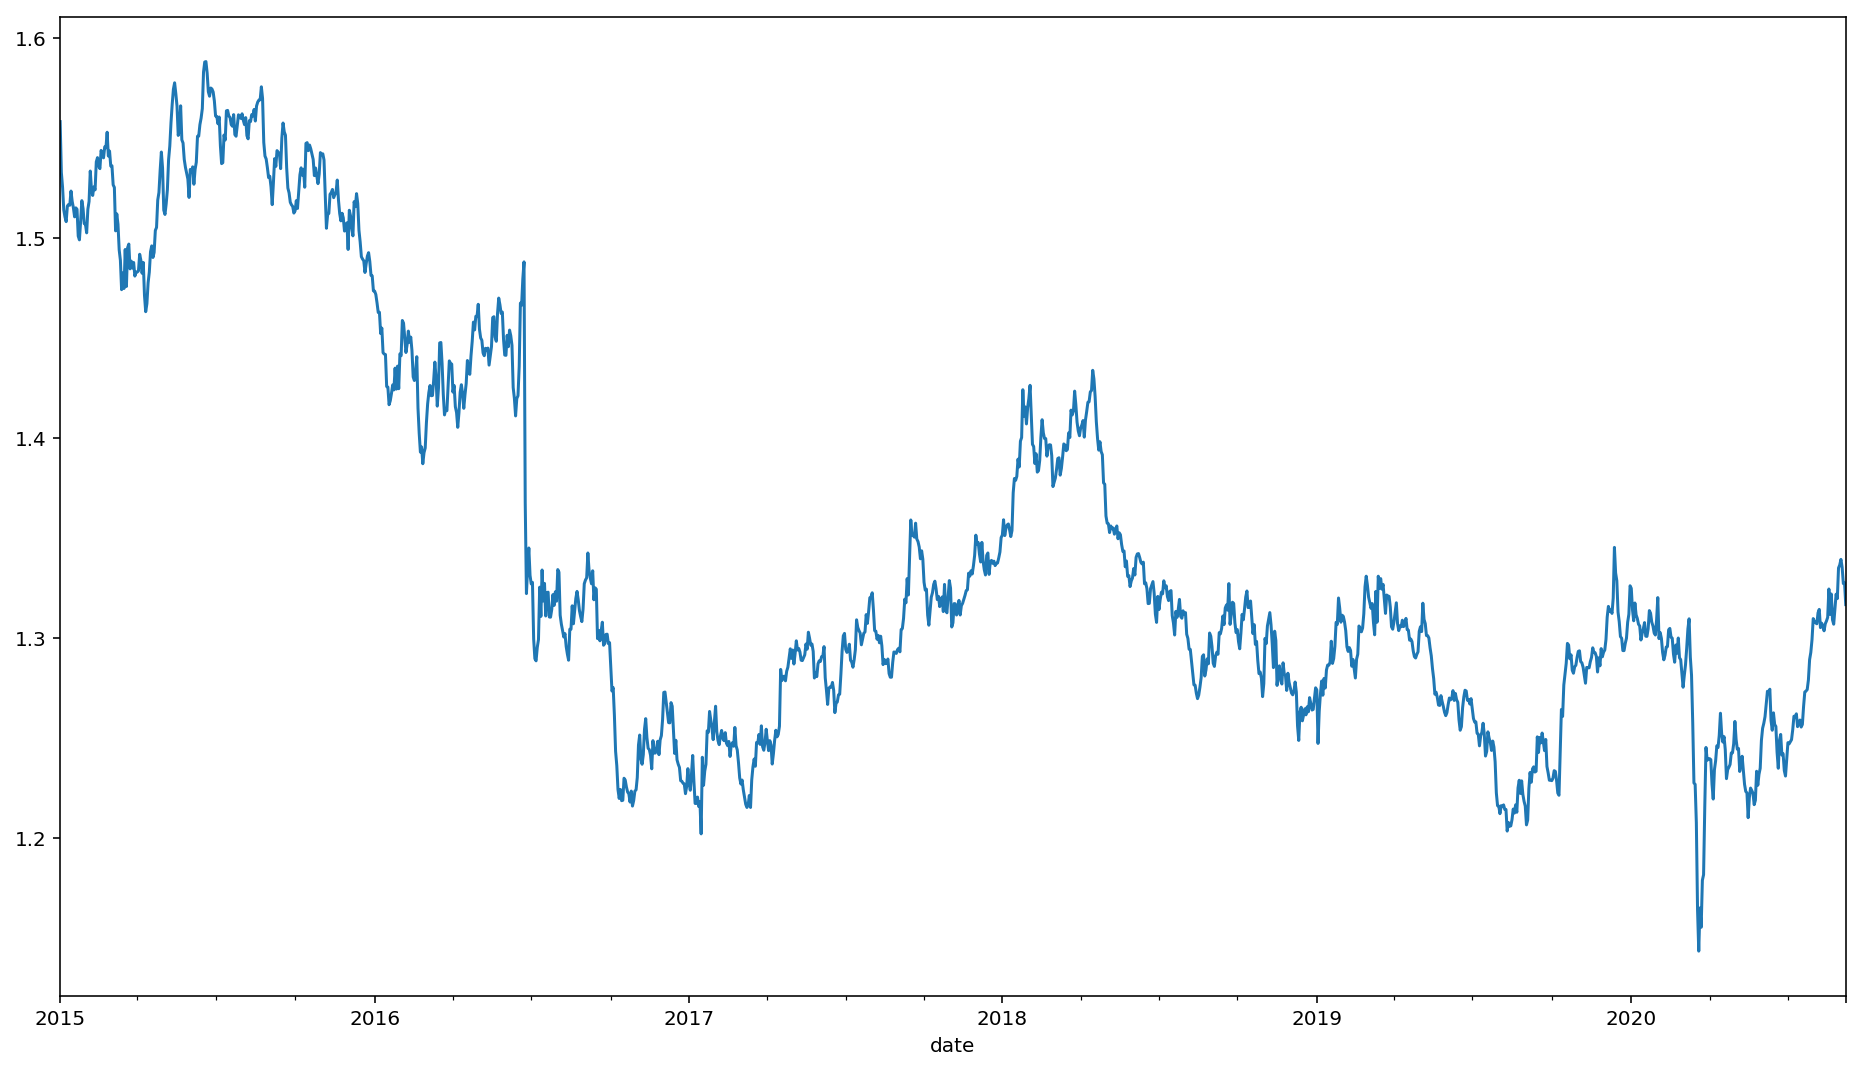

In [17]:
data_df['4. close'].plot()

In [18]:
data_df = data_df.loc[:, ['2. high', '3. low', '1. open', '4. close']]
data_df.columns = ['High', 'Low', 'Open', 'Close']

In [19]:
data = bt.feeds.PandasData(dataname=data_df)

# Strategy Definition 

In [50]:
class boll_bander(bt.Strategy):
    params = dict(
    bfast=5
    ,bslow=25
    ,dev=1.5)
    
    def __init__(self):
        self.bollf = bt.ind.BollingerBands(period=self.p.bfast, plot=True, plotname='fast Bollinger', subplot=False)
        
        self.bollslow = bt.ind.BollingerBands(period=self.p.bslow, devfactor=self.p.dev, plot=True, plotname='Slow Bollinger', subplot=False)
        
        self.buysig = bt.indicators.CrossOver(self.data0, self.bollslow.lines.bot, plotname='buy signal', plot=True)
        
        self.sellsig = bt.indicators.CrossOver(self.data0, self.bollslow.lines.top,plotname='sell signal', plot=True)

    def next(self):
        
        if not self.position:  # not in the market
            if self.buysig > 0:  # if fast crosses slow to the upside
                self.order_target_size(target=2000)   # enter long
                
        elif self.sellsig > 0:  # in the market & cross to the downside
            self.order_target_size(target=0)   # close long position 
        

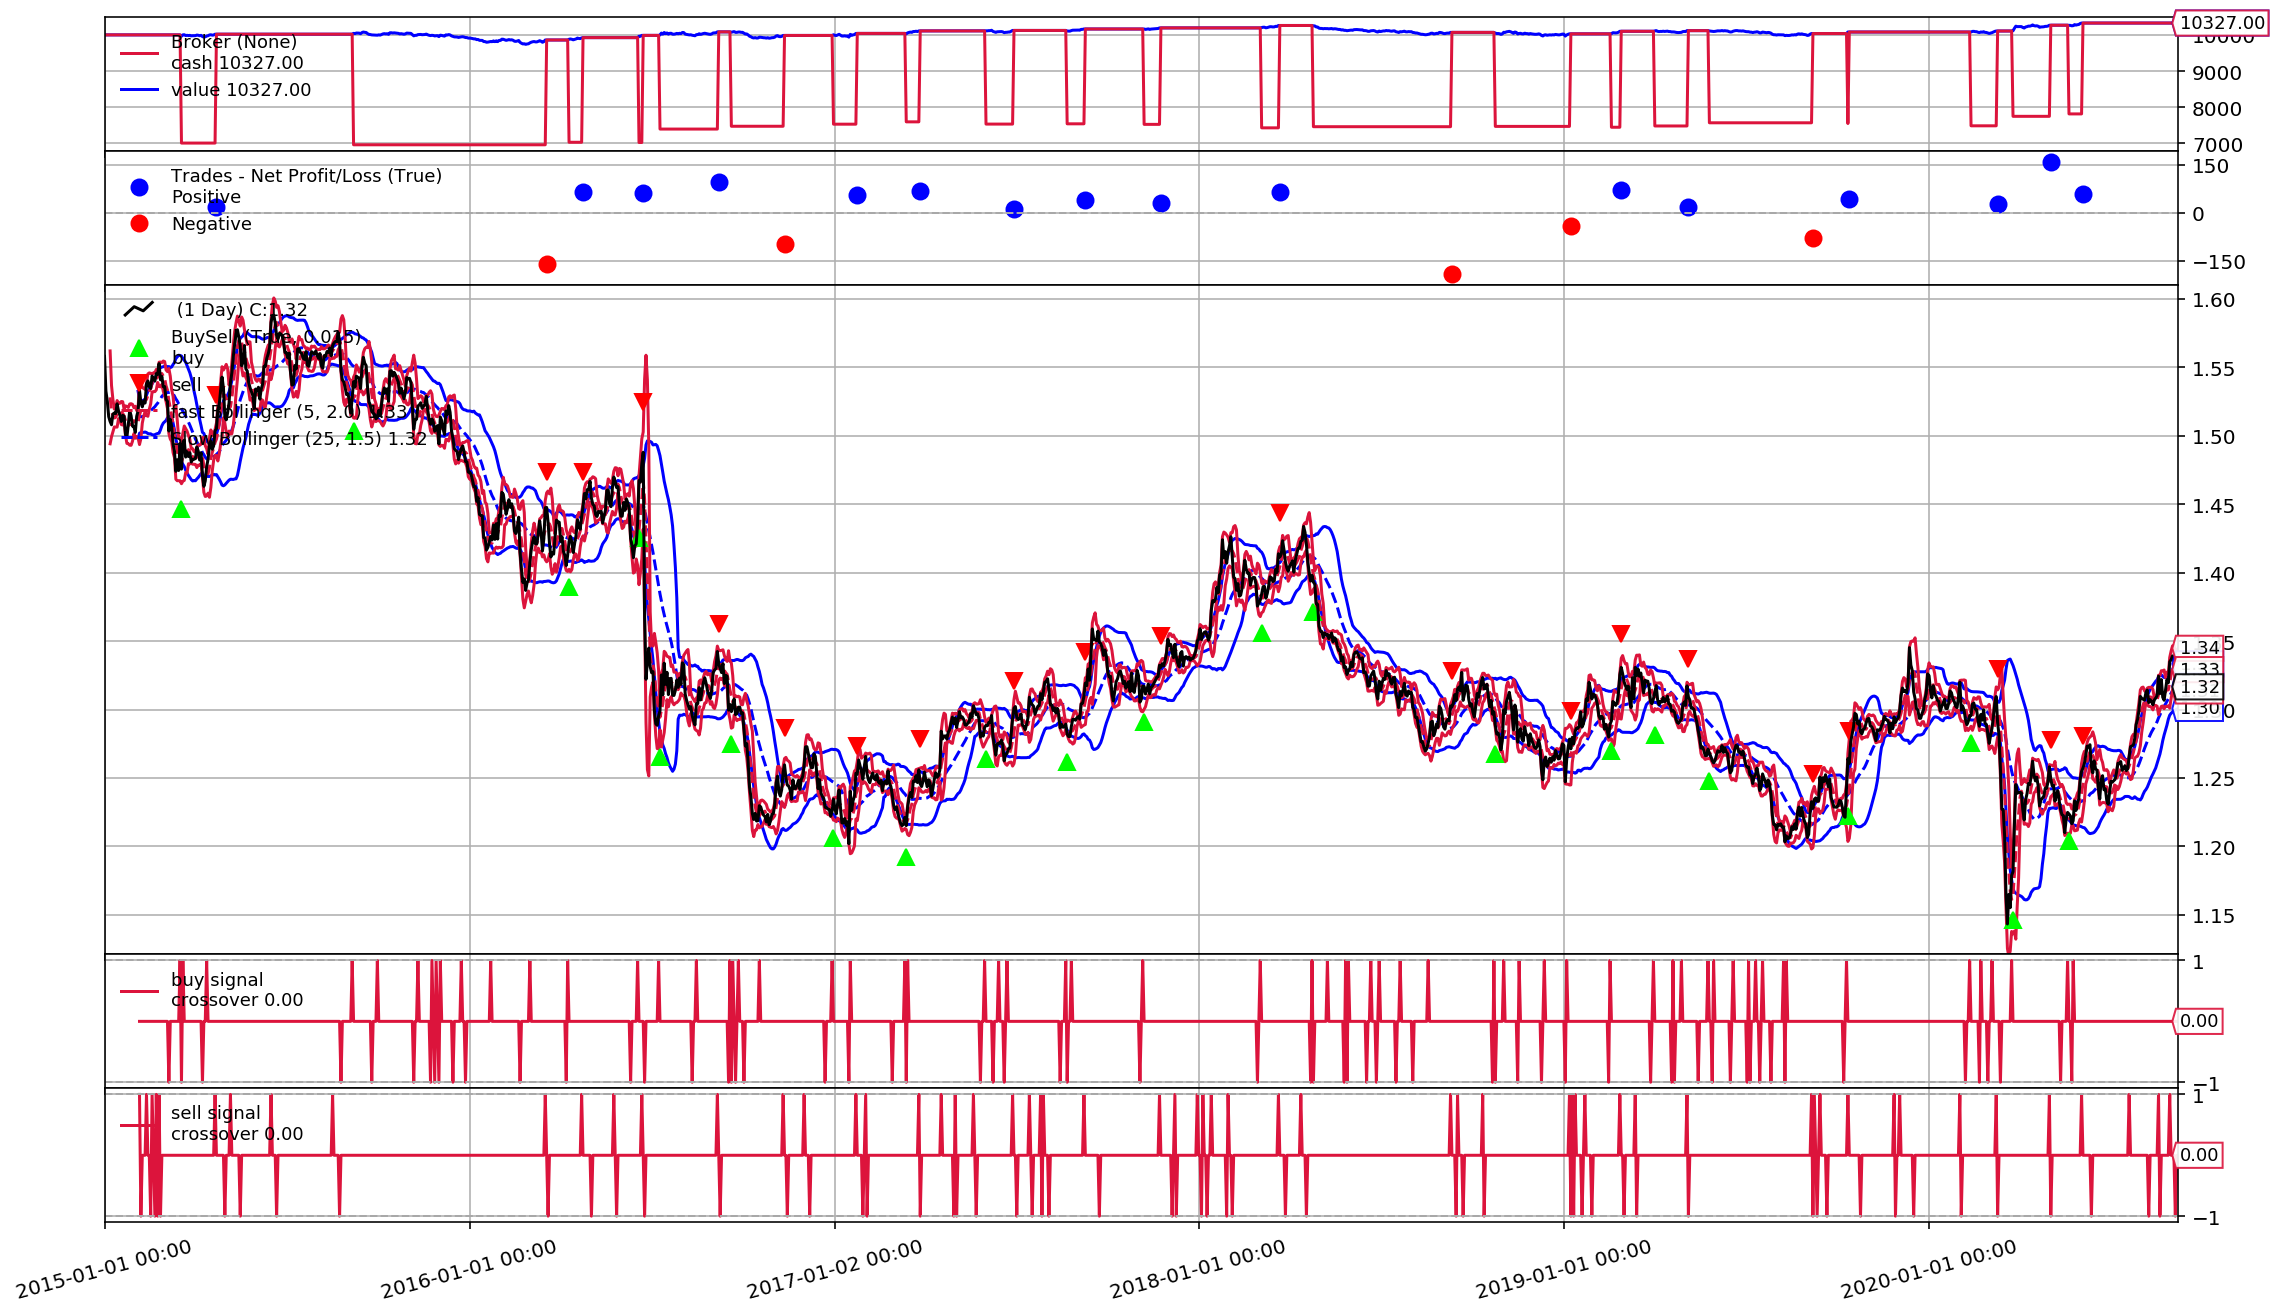

CPU times: user 2.24 s, sys: 832 ms, total: 3.07 s
Wall time: 1.72 s


[[<Figure size 1152x648 with 5 Axes>]]

In [53]:
%%time
cerebro = bt.Cerebro()
cerebro.adddata(data)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
cerebro.addstrategy(boll_bander)
results = cerebro.run()
cerebro.plot(iplot=False, volume=False, width=20)